This notebook evaluate WRF-Chem modeled surface pollutants with ground based observations over Delhi NCT.

In [1]:
#import modules
%run ../load_main.py
from Air_Quality_notebooks import utils as utl
from WRFChemToolkit.analysis import statistics as st

## Get model Delhi NCT data

In [2]:
# laod otuputs
post=xr.open_mfdataset('/exports/geos.ed.ac.uk/palmer_group/managed/s1878599/delhiAQ/delhiNCT/outputs_postmon/pblmincoeff_tests/wrfout_d01_2019-10-*_00:00:00_nest_2019_newdyno_exchmin5.nc')

In [3]:
#season
season='postmonsoon'

In [4]:
#put data in dictionary
s={'post':post}

In [5]:
def reset_time_dim(ds):
    """
    Time dimension in WRF-Chem datasets is just the time index [0,1,2,3...].
    This function convert dimension Time as datetime[64].
    :param ds:
     wrf-chem xarray dataset.
    :type ds:xarray.Dataset.
    :return:
     xarray.Dataset with datetime time dim.
    :rtype: xarray.Dataset.
    """
    return ds.assign_coords(Time=pd.to_datetime(ds.XTIME.values))

In [6]:
# reset time and discard 5 days  spinup period.
s['post']=reset_time_dim(s['post']).sel(Time=slice('2019-10-06T00:00:00.000000000','2019-10-16T00:00:00.000000000')) # 5 days

In [7]:
# subset surface values of relevant pollutants.

In [8]:
# define conversions from ppmv (wrfchem model) to ug/m3 (observations)
def gas_ppm_to_ugm3(ds,gas,mol_w):
    """Convert gas from ppmv to ug/m3 based on molar weight of gas
    from  https://www.acom.ucar.edu/wrf-chem/ConversionMozartWRFChem.pdf"""
    ds[gas + "_ugm3"]=((ds[gas]/1e6)*(mol_w/29)*1e9)/ds.ALT
    ds[gas + "_ugm3"].attrs["units"]="ug m-3"

#gas pollutants and their molar weight.
mw={"o3":48} 

# add converted quantitites
for v in s.values():
    for p,m in mw.items():
            gas_ppm_to_ugm3(v,p,m)

In [9]:
# define function to get pollutants and variables of interest.
def get_pollutants(ds):
    
    data ={ 
           "pm25" : (['time',"lat","lon"], ds.PM2_5_DRY.values[:,0,:,:]),           
           "PBLH" : (['time',"lat","lon"], ds.PBLH.values[:,:,:]),
          }
    coords={'time': (['time'], ds.XTIME[:]),'lat': (['lat'], ds.XLAT[0,:,0]), 'lon': (['lon'], ds.XLONG[0,0,:])}
    p = xr.Dataset(data, coords=coords)
    return p

In [10]:
# get selected pollutants in a dictionary by season
mod={}
for k,v in s.items():
    mod.update({k:get_pollutants(v)})

In [11]:
# extract Delhi NCT data only using shapefile
from WRFChemToolkit.analysis import aerosols_202 as aer, plots as pt, statistics as st
import salem
shp = '../gadm_data/delhiNCT/delhiNCT.shp'
for k,v in mod.items():
    mod[k]= mod[k].salem.roi(shape=shp)

# Get observations over Delhi NCT

In [12]:
# load observations data
pth ='../observations/cpcb_oct2019_cleaned.xlsx'  # new downloaded direclty from CPCB website.
data=pd.read_excel(pth)

In [13]:
# add utc time to observations
from datetime import timedelta
data['date_UTC'] = pd.to_datetime(data['date_UTC'], format='%Y-%m-%d %H:%M:%S')

#select observation corresponding to model output time range (UTC)
data=data.set_index('date_UTC')[str(mod['post'].time.min().values):str(mod['post'].time.max().values)].reset_index() 

In [14]:
data.date_UTC.min()

Timestamp('2019-10-06 00:00:00')

In [15]:
mod['post'].time.max().values

numpy.datetime64('2019-10-16T00:00:00.000000000')

In [16]:
#create dict with datasets with dyno mean and std
obs={}
pol=['pm25'] 
for pl in pol:
    df = data[['hour_LT',pl]].groupby('hour_LT').agg({'mean', 'std'})[pl].add_prefix(pl + "_obs_").reset_index().rename(columns={'hour_LT':'hour'})
    obs.update({pl:df})

In [17]:
obs['pm25'].pm25_obs_mean.mean()

94.8598381051042

# Define evaluation metrics

In [18]:
# import scipy.stats as ss
import statsmodels.api as sm
import numpy as np

def len_err(x,y):
    if len(x) != len(y):
        raise Exception("Number of observation datapoints is different from number of model datapoints.")


def get_MB(o,m):
    "Calculate the mean bias from model and observation. m and o are array of model and observations."
    len_err(o,m)
    return sum(m-o)/len(o)

def get_NMB(o,m):
    "Normalised mean bias"
    len_err(o,m)
    return sum(m-o)/sum(o)

def get_RMSE(o,m):
    "Normalised mean bias"
    len_err(m,o)
    return (sum((m-o)**2)/len(o))**0.5

def get_NMAE(o,m):
    "Normalised mean absolute error"
    len_err(o,m)
    return sum(abs(m-o))/sum(o)

def get_r(o,m):
    import scipy.stats as ss
    "pearson coefficient and p value"
    len_err(o,m)
    return ss.pearsonr(o,m)

def get_fit(o,m):
    "linear regression slope values"
    model = sm.OLS(m, o)
    ln=model.fit()
    return ln.params

In [19]:
# create dataframe where to save metrics
metr = pd.DataFrame(columns= ["pollutant","season","NMB","NMAE","MB [ug/m3]","RMSE [ug/m3]","r"])
metr['season'] =['post']
metr['pollutant'] = ["pm25"]
metr= metr.sort_values(["pollutant","season"])

In [20]:
metr

,pollutant,season,NMB,NMAE,MB [ug/m3],RMSE [ug/m3],r
0,pm25,post,NaN,NaN,NaN,NaN,NaN


In [21]:
# Define plots functions

In [22]:
import matplotlib.pyplot as plt
def plot_avg_Delhi_ax(df_m,df_o,spc,ax):
    ax.errorbar(df_o[spc]['hour'],df_o[spc][spc+'_obs_mean'],fmt='o-',markersize=8,label='OBS',color='#5D3A9B')
    ax.errorbar(df_m[spc]['hour'],df_m[spc][spc+'_mod_mean'],fmt='o-',markersize=8,label='MOD',color='#E66100') 
    #ax.set_title('average dyno over Delhi - '+spc)

    ax.set_ylabel('$\mu g~m^{-3}$',fontsize=12)
        
    ax.legend(ncol=2,loc=[0.2,1.01],fontsize=12)
    
    # shadows errors
    ax.fill_between(df_o[spc]['hour'], df_o[spc][spc+'_obs_mean']+ df_o[spc][spc+'_obs_std'], df_o[spc][spc+'_obs_mean']- df_o[spc][spc+'_obs_std'],alpha=0.3,color='#5D3A9B')
    ax.fill_between(df_o[spc]['hour'], df_m[spc][spc+'_mod_mean']+ df_m[spc][spc+'_mod_std'], df_m[spc][spc+'_mod_mean']- df_m[spc][spc+'_mod_std'], alpha=0.3,color='#E66100')
   
    
    # add PBL height
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(df_m['PBLH']['hour'],df_m['PBLH']['PBLH_mod_mean'],'-',linewidth=1,label = "PBLH",color='grey',linestyle='-')
    ax2.set_ylabel('meters',fontsize=12)
    ax2.legend(ncol=1,loc=[0.65,1.01],fontsize=12)

    plt.style.use('seaborn-bright')

## Dyno cycle evalaution: average over all NCT model gridpoints vs average over all obs stations

In [23]:
# Spatial average over Delhi NCT 
mod_sp={}
for k,v in mod.items():
    mod_sp[k]= mod[k].mean(['lat','lon'])

In [24]:
#create dict with datasets with dyno mean and std in Local Time
from datetime import timedelta
model={}
for v in mod['post'].data_vars:
    df = mod['post'][v].to_dataframe().reset_index()
    # get local time
    df['date_LT'] = df['time'] +timedelta(hours=5.5)
    df['hour'] = df['date_LT'].dt.hour
    df.drop('time',axis=1, inplace=True)
    
    # groupby hour
    df=df.groupby('hour').agg({'mean', 'std'})[v].add_prefix(v + "_mod_").reset_index()
    model.update({v:df})
    # TO DO: NEED TO ADD VARIABILITY ON SPATIAL AVERAGE AS WELL. THIS IS ONLY TIME AVERAGE.

In [25]:
model['pm25'].pm25_mod_mean.mean()

102.83853912353516

In [26]:
# Calculate metrics for each pollutant and each season
s='post'
for k,v in obs.items(): # loop over pollutants df in observations.
    print(k)                       
    o=obs[k][k+'_obs_mean'].apply(np.array)     # get array of observations and values by season
    m=model[k][k+'_mod_mean'].apply(np.array)
    metr.loc[(metr.season == s) & (metr.pollutant==k),"MB [ug/m3]"] =get_MB(o,m) 
    metr.loc[(metr.season == s) & (metr.pollutant==k), "NMB"] = get_NMB(o,m) 
    metr.loc[(metr.season == s) & (metr.pollutant==k), "RMSE [ug/m3]"] = get_RMSE(o,m)
    metr.loc[(metr.season == s) & (metr.pollutant==k), "NMAE"] = get_NMAE(o,m) 
    metr.loc[(metr.season == s) & (metr.pollutant==k), "r"] =get_r(o,m)[0]

pm25


In [27]:
metr

,pollutant,season,NMB,NMAE,MB [ug/m3],RMSE [ug/m3],r
0,pm25,post,0.0841104,0.126701,7.9787,12.8304,0.888583


In [28]:
# plots

pm25


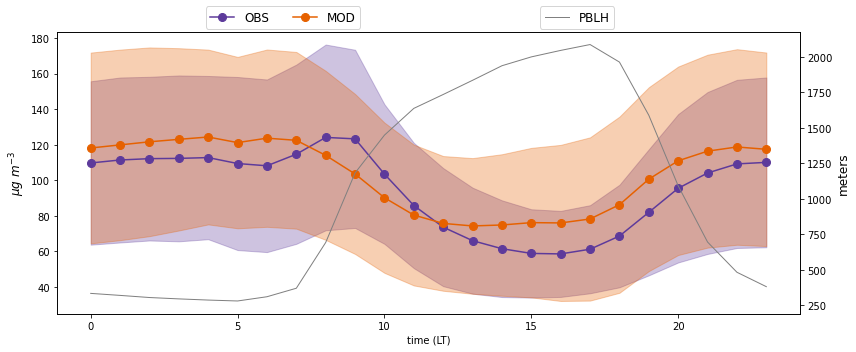

In [29]:
fig, axes = plt.subplots(1,1,figsize=(12,5))
for pl,ax in zip(pol,fig.axes):  #p in obs.keys()
    print(pl)
    plot_avg_Delhi_ax(model,obs,pl,ax)
    
    ax.set_xlabel('time (LT)')
    ax.tick_params(axis='x', labelsize=10)
            
fig.tight_layout()
fig.show()

# Dyno cycle evalaution: average over all NCT at observations stations gridpoints vs average observations

In [30]:
#create observations dictionary with dyno cycle mean and std in Local Time
data['date_LT'] = pd.to_datetime(data['date_LT'], format='%Y-%m-%d %H:%M:%S')
data['hour']=data['date_LT'].dt.hour
dyno_st=data.groupby(['station','hour']).mean().reset_index()

In [31]:
#create model dicitonary with dyno mean and std in Local Time by station
from datetime import timedelta
mod_latlon={}
for v in mod['post'].data_vars:
    print(v)
    df = mod['post'][v].to_dataframe().reset_index()
    # get local time
    df['date_LT'] = df['time'] +timedelta(hours=5.5) # son 5.5 hr
    df['hour'] = df['date_LT'].dt.hour
    df.drop('time',axis=1, inplace=True)
    
    # grupby hour
    df=df.groupby(['lat','lon','hour']).agg({'mean', 'std'})[v].add_prefix(v + "_obs_")
    mod_latlon.update({v:df.to_xarray()})

pm25
PBLH


In [32]:
mod_latlon['pm25']

<xarray.Dataset>
Dimensions:        (hour: 24, lat: 147, lon: 147)
Coordinates:
  * lat            (lat) float64 25.4 25.44 25.48 25.51 ... 30.68 30.72 30.75
  * lon            (lon) float64 73.97 74.01 74.05 74.09 ... 79.95 79.99 80.04
  * hour           (hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Data variables:
    pm25_obs_mean  (lat, lon, hour) float32 nan nan nan nan ... nan nan nan nan
    pm25_obs_std   (lat, lon, hour) float32 nan nan nan nan ... nan nan nan nan

In [33]:
# subsect observation to correspond to model outputs

In [34]:
o=dyno_st
for k in pol:  # POLL loop over pollutants df in observations.
    
    o["mod_time"]=0.0
    o["mod_lat"]=0.0   # add columns to store model data
    o["mod_lon"]=0.0 
    o["mod_"+k]=0.0 
    o["mod_pblh"]=0.0
    o["mod_"+k+'_std']=0.0
            
    for idx, row in o.iterrows():# get model values row by row
        da = mod_latlon[k]
        #da = mod[row["season"]][k] # select relevant data array based on season and pollutant
        m = da.sel( # get model gridpoint closest to obs lat lon(nearest method) 
                   lat=row["lat"],
                   lon=row["lon"],
                   method='nearest') 
        m=m.sel(hour=row['hour'])  #get only times in the data.
        o["mod_time"][idx]=str(m.hour.values)
        o["mod_lat"][idx]=float(m.lat) # save lat, lon and pollutant value as separate columns
        o["mod_lon"][idx]=float(m.lon)
        o["mod_"+k][idx]=float(m[k+'_obs_mean'])
        o["mod_"+k+'_std'][idx]=float(m[k+'_obs_std'])
       
    # add pblh
        da_pb = mod_latlon['PBLH']
        m_pb = da_pb.sel( # get model gridpoint closest to obs lat lon(nearest method) 
                  lat=row["lat"],
                   lon=row["lon"],
                   method='nearest') 
        m_pb=m_pb.sel(hour=row['hour'])  #get only times in the data.
        o['mod_pblh'][idx]=float(m_pb['PBLH_obs_mean'])     

In [35]:
o.columns

Index(['station', 'hour', 'Unnamed: 0', 'lat', 'lon', 'month_LT', 'month_UTC',
       'day_LT', 'hour_LT', 'day_UTC', 'hour_UTC', 'pm25', 'o3', 'no', 'no2',
       'nox', 'rh', 'temp', 'mod_time', 'mod_lat', 'mod_lon', 'mod_pm25',
       'mod_pblh', 'mod_pm25_std'],
      dtype='object')

In [36]:
#create dict with datasets with dyno mean and std in Local Time
from datetime import timedelta
d={}
for v in pol:
    # grupby hour
    dfo=o.groupby('hour').agg({'mean', 'std'})[v].add_prefix(v + "_obs_").reset_index()
    dfm=o.groupby('hour').agg({'mean', 'std'})['mod_'+v].add_prefix(v + "_mod_").reset_index()
    d.update({v:pd.merge(dfo,dfm)})

In [37]:
#add PBLH
d['PBLH']=model['PBLH']

In [38]:
d['pm25']['pm25_obs_mean'].mean()

94.82279269334764

In [39]:
d['pm25']['pm25_mod_mean'].mean()

108.82265169389785

In [40]:
# Calculate metrics for each pollutant and each season
s='post'
for k in pol: # loop over pollutants df in observations.
    print(k)                       
    o=d[k][k+'_obs_mean'].apply(np.array)     # get array of observations and values by season
    m=d[k][k+'_mod_mean'].apply(np.array)
    metr.loc[(metr.season == s) & (metr.pollutant==k),"MB [ug/m3]"] =get_MB(o,m) 
    metr.loc[(metr.season == s) & (metr.pollutant==k), "NMB"] = get_NMB(o,m) 
    metr.loc[(metr.season == s) & (metr.pollutant==k), "RMSE [ug/m3]"] = get_RMSE(o,m)
    metr.loc[(metr.season == s) & (metr.pollutant==k), "NMAE"] = get_NMAE(o,m) 
    metr.loc[(metr.season == s) & (metr.pollutant==k), "r"] =get_r(o,m)[0]

pm25


In [41]:
metr

,pollutant,season,NMB,NMAE,MB [ug/m3],RMSE [ug/m3],r
0,pm25,post,0.147642,0.168531,13.9999,17.135,0.894696


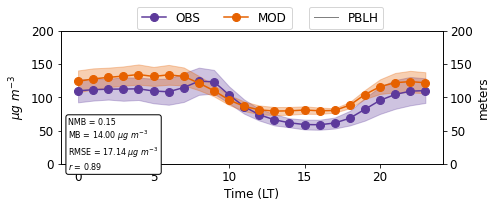

In [42]:
fig, axes = plt.subplots(1,1,figsize=(7,3))
for p,ax in zip(pol,fig.axes):
    plot_avg_Delhi_ax(d,d,p,ax)
    model,obs,pl,ax
    
for ax in fig.axes:
#    if ax==fig.axes[7]  or ax==fig.axes[6]:
    ax.set_xlabel('Time (LT)',fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
#    else:
#         ax.xaxis.set_ticklabels([])
    ax.set_ylim((0,200))

textstr = '\n'.join((
    r'NMB = 0.15' ,
    r'MB = 14.00 $\mu g~m^{-3}$' ,
    r'RMSE = 17.14 $\mu g~m^{-3}$'  ,
    r'$r$ = 0.89'))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)

# place a text box in upper left in axes coords
ax.text(0.02, 0.35, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)

fig.tight_layout()


In [43]:
fig.savefig('./fig03.pdf', format='pdf', dpi=300)